# Causal Inference Method (Difference-in-Differences): Measuring the Effect of a new Customer-Satisfaction Program at an Airline Company

## Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [ ]:
# Initial Setup
print("Current Working Directory:", os.getcwd())

## Exploratory Data Analysis

Before we dive into the questions, let's do the following **basic** procedures:
1) Data Overview
2) Clean the data
    * Handle Missing Values
    * Remove Duplicates
    * Other possible checks: data types (I quickly checked, and it is all okay, so I will jump this part)

In [ ]:
# 1. Data Overview

# Load the CSV file using the correct path
# Rename the first column
df = pd.read_csv(r"C:\Users\caiov\OneDrive - UCLA IT Services\Documentos\DataScience\Repositories\airline_project\data\nps_experiment_v2.csv")
df.rename(columns={df.columns[0]: 'id'}, inplace=True)

print("File loaded successfully.")
print(df.head())

print("\nData types and missing values:")
print(df.info())

File loaded successfully.
   id   nps_post   nps_pre airports  improved_counter_service  pair_id
0   0   6.041131  4.504505     Alta                         1        1
1   1  33.804627  6.936937     Alta                         1        2
2   2  58.483290  8.738739     Alta                         1        3
3   3   0.000000  0.000000     Alta                         1        4
4   4  42.802057  5.855856     Alta                         1        5

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        192 non-null    int64  
 1   nps_post                  192 non-null    float64
 2   nps_pre                   192 non-null    float64
 3   airports                  192 non-null    object 
 4   improved_counter_service  192 non-null    int64  
 5   pair_id               

In [4]:
# 2. Data Cleaning

# Handle Missing Values
print("\nMissing values in each column:")
print(df.isnull().sum())
print("--> There are no missing data.")

# Remove Duplicates
print("\nNumber of duplicate rows: ", df.duplicated().sum())
print("--> There are no duplicates.")


Missing values in each column:
id                          0
nps_post                    0
nps_pre                     0
airports                    0
improved_counter_service    0
pair_id                     0
dtype: int64
--> There are no missing data.

Number of duplicate rows:  0
--> There are no duplicates.


## Questions

### Question 1
**Based on the description generated in the previous point, identify which elements would be the target vector, the treatment, and possible covariates. Additionally, indicate what hypotheses we could generate regarding this intervention.**

* Before answring, it is important to state that the setup of this project appears suitable for a Differences-in-Differences (DiD) approach, because:
    * We have *pre* and *post* intervention data: We have `nps_pre` (pre-intervention NPS) and `nps_post` (post-intervention NPS) for each passenger.
    * *Treatment* and *Control* Groups: The variable `improved_counter_service` indicates whether a passenger received the new service (treatment group) or not (control group).
    * *Group Comparison*: You can compare the changes in NPS scores over time between the treatment and control groups.

**Now, back to the question:**

Target Variable, Treatment, and Covariates

* Target Variable:
    * The Target Variable is the measured characteristic the treatment is designed to effect.
    * `nps_post`: This is the Net Promoter Score recorded after the intervention. Since the objective of the study is to measure how the CounterXP protocol affects customer satisfaction (as reflected in the NPS), nps_post is the outcome variable that you are analyzing to determine the effect of the intervention.
* Treatment:
    * The 
    * `improved_counter_service`: This binary variable indicates whether the passenger received the new CounterXP service (1 for yes, 0 for no). This is the treatment whose effect you are measuring.
* Covariates:
    * `nps_pre`: The Net Promoter Score before the intervention. This serves as a baseline measure and helps control for individual differences in pre-existing satisfaction.
    * `airports`: The type of airport, which could impact NPS due to varying levels of operational demand. This helps control for contextual differences between airports.
    * `pair_id`: This identifier indicates matched pairs of passengers, which can help control for other covariates by ensuring that comparisons are made between similar individuals.

Hyphoteses

Let's keep it simple.

* Hypothesis 1 (Effect of CounterXP):
    * Null Hypothesis (H0): There is no significant difference in `nps_post` between passengers who received the CounterXP service and those who did not.
    * Alternative Hypothesis (H1): There is a significant difference in `nps_post` between passengers who received the CounterXP service and those who did not, indicating that the CounterXP protocol has an effect on customer satisfaction.
* Hypothesis 2 (Impact of Covariates):
    * Null Hypothesis (H0): The change in NPS (from pre to post) is consistent across different levels of covariates (such as `airport` type and `nps_pre`).
    * Alternative Hypothesis (H1): The change in NPS is influenced by covariates like `airport` type and initial NPS (`nps_pre`), indicating that these factors impact the effectiveness of the CounterXP intervention.

### Question 2
**Perform a descriptive analysis of the behavior of the target vector, considering its pre- and post-intervention measurements, as well as its behavior conditional on intervention status.**

* Unconditional Analysis: Gives a general sense of the NPS scores before and after the intervention across all passengers.
* Conditional Analysis: Provides insights into how the intervention impacted the NPS scores compared to the control group, helping to understand the effectiveness of CounterXP.


Summary statistics for numerical columns:
       nps_pre  nps_post
count   192.00    192.00
mean     67.54     68.06
std      26.34     22.83
min       0.00      0.00
25%      56.73     54.95
50%      76.71     74.68
75%      86.76     85.86
max     100.00    100.00


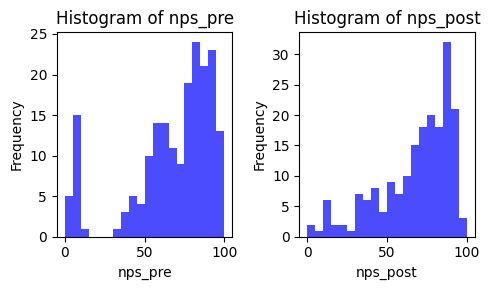

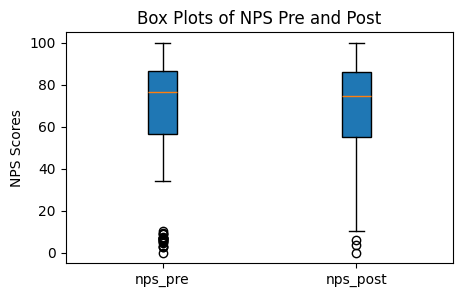

In [5]:
# Unconditional Analysis of the Target Variable (NPS)

# Variables of interest
variables_of_interest = ['nps_pre', 'nps_post']

# Summary Statistics
print("\nSummary statistics for numerical columns:")
print(df[variables_of_interest].describe().round(2))

# Distribution Analysis
# Plot histograms for the selected variables
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed

for i, col in enumerate(variables_of_interest, 1):
    plt.subplot(1, 2, i)
    plt.hist(df[col], bins=20, color='blue', alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot Box Plots
# Extract the data for the box plots
data_to_plot = [df[col].dropna() for col in variables_of_interest]

# Plot box plots for the selected variables in the same chart
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed

plt.boxplot(data_to_plot, patch_artist=True, tick_labels=variables_of_interest)
plt.title('Box Plots of NPS Pre and Post')
plt.ylabel('NPS Scores')

plt.show()

**Interpretation of the Unconditional `nps_pre` vs `nps_post`**
* Histograms
    * Shape and Spread
        * Both `nps_pre` and `nps_post` distributions are somewhat similar, with a noticeable concentration of scores around the 55-87 range.
        * Both histograms show a peak around the 75-85 range, indicating that a significant number of observations have NPS scores in this range.
    * Skewness
        * Both distributions exhibit a slight left skew (longer tail on the left side), with some observations having very low NPS scores, even at 0.
        * The presence of scores at 0 suggests that there are customers with very negative experiences both before and after the intervention.
    * Final Thoughts
        * The `nps_post` histogram shows a slight increase in the scores around the 70-85 range compared to the `nps_pre` distribution.
        * This suggests that the intervention may have had a positive impact, as seen by a shift in the distribution towards higher scores after the intervention. However, the change is not drastic, indicating that the intervention might have had a moderate effect on improving customer satisfaction.
        * **One notable observation** is the **disappearance of the peak in negative evaluations**, as seen in the histogram. While the mean and median haven't changed drastically, and the overall distribution shape remains similar, the reduction in negative feedback could imply a positive impact of the intervention.
            * This suggests that the intervention might have successfully mitigated some of the lower-end dissatisfaction among participants, which is a critical insight despite the overall statistical measures showing minimal change.
* Boxplots
    * Central tendency (Mean and Median)
        * The means of `nps_pre` and `nps_post` are very close (67.54 and 68.06, respectively), indicating a small overall increase in average NPS after the intervention.
        * The median values also show a similar pattern, with a slight decrease from `nps_pre` (76.71) to `nps_post` (74.68), suggesting that the distribution's central point has shifted slightly downward after the intervention.
    * Spread (Standard Deviation and Interquartile Range)
        * The standard deviation of `nps_pre` (26.34) is slightly higher than that of `nps_post` (22.83), suggesting that there was more variability in the NPS scores before the intervention.
        * The IQRs are quite similar for both `nps_pre` (86.76 - 56.73 = 30.03) and `nps_post` (85.86 - 54.95 = 30.91), indicating that the spread of the middle 50% of the data has not changed significantly after the intervention.
    * Extremes
        * Both `nps_pre` and `nps_post` have the same minimum and maximum values, indicating that the range of NPS scores (from 0 to 100) has remained unchanged before and after the intervention.
    * Final Thoughts
        * These insights suggest that while the intervention might have had a minor impact on the overall NPS, the general distribution of scores remained consistent. This could indicate that the intervention's effect was subtle or that other factors also influenced NPS scores during the period.

In [6]:
# Conditional Analysis of the Target Variable (NPS), conditioning on the intervencion status
print("\nDescriptive statistics by improved_counter_service (intervention status):")
print(df.groupby('improved_counter_service')[variables_of_interest].describe())


Descriptive statistics by improved_counter_service (intervention status):
                         nps_pre                                              \
                           count       mean        std        min        25%   
improved_counter_service                                                       
0                           96.0  77.045796  16.579405  34.414414  65.855856   
1                           96.0  58.043356  30.620121   0.000000  47.882883   

                                                           nps_post  \
                                50%        75%         max    count   
improved_counter_service                                              
0                         81.486486  91.373874   98.378378     96.0   
1                         65.450450  82.882883  100.000000     96.0   

                                                                     \
                               mean        std       min        25%   
improved_counter_service  

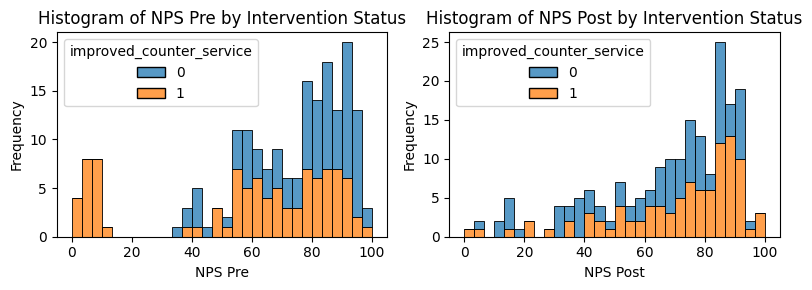

In [7]:
# Histograms for nps_post and nps_pre by intervention status
plt.figure(figsize=(8, 3))

# Histogram for nps_pre by intervention status
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='nps_pre', hue='improved_counter_service', multiple='stack', bins=30)
plt.title('Histogram of NPS Pre by Intervention Status')
plt.xlabel('NPS Pre')
plt.ylabel('Frequency')

# Histogram for nps_post by intervention status
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='nps_post', hue='improved_counter_service', multiple='stack', bins=30)
plt.title('Histogram of NPS Post by Intervention Status')
plt.xlabel('NPS Post')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

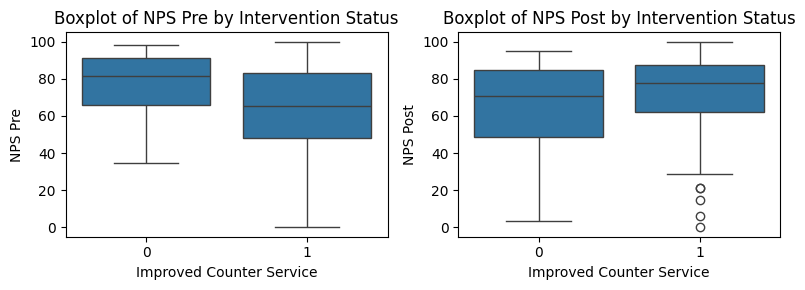

In [8]:
# Boxplots for nps_post and nps_pre by intervention status
plt.figure(figsize=(8, 3))

# Boxplot for nps_pre
plt.subplot(1, 2, 1)
sns.boxplot(x='improved_counter_service', y='nps_pre', data=df)
plt.title('Boxplot of NPS Pre by Intervention Status')
plt.xlabel('Improved Counter Service')
plt.ylabel('NPS Pre')

# Boxplot for nps_post
plt.subplot(1, 2, 2)
sns.boxplot(x='improved_counter_service', y='nps_post', data=df)
plt.title('Boxplot of NPS Post by Intervention Status')
plt.xlabel('Improved Counter Service')
plt.ylabel('NPS Post')

plt.tight_layout()
plt.show()

**Interpretation of `nps_pre` Conditional on `improved_counter_service`.**

* Before the Intervention (improved_counter_service = 0)
    * $NPS_{pre, intervention = 0} = 77$
    * This represents the Net Promoter Score (NPS) before the intervention was implemented. 
    * It gives us a baseline measure of customer satisfaction before any changes were made.

* After the Intervention (improved_counter_service = 1):
    * $NPS_{pre, intervention = 1} = 58$
    * This shows the NPS before the intervention for those who eventually experienced the intervention.
    * This score is essentially the same as `nps_pre` for the control group but collected from the subset of data that will later receive the intervention.

**Interpretation of `nps_post` Conditional on `improved_counter_service` Status**

* Before the Intervention (improved_counter_service = 0)
    * $NPS_{post, intervention = 0} = 64.4$
    * This measures the NPS after the intervention was implemented, but for those who did not experience the intervention.
    * This score helps us understand the effect of the passage of time or other external factors on customer satisfaction for the non-intervention group.

* After the Intervention (improved_counter_service = 1):
    * $NPS_{post, intervention = 1} = 71.7$
    * This measures the NPS after the intervention for those who received it. 
    * This score directly reflects the impact of the intervention on customer satisfaction.

**Final Thoughts**
* Change in NPS for those who did not experienced the new protocol:
    * The decrease from 77 to 64.4 indicates that satisfaction levels have dropped, which could be attributed to external factors or changes not related to the intervention.
* Change in NPS for those who experienced the new protocol:
    * The increase from 58 to 71.7 shows a positive effect of the intervention. The improvement in satisfaction after receiving the intervention suggests that the intervention was successful in enhancing customer satisfaction for this group.
* The intervention appears to have been effective:
    * It improved the NPS for those who received it (from 58 to 71.7).
    * Despite the lower NPS_pre among those who received the intervention, the NPS_post is now higher than the NPS_post of those who did not receive it. 
    * In essence, the intervention had a beneficial effect on customer satisfaction, particularly for those who initially had lower satisfaction scores.

### Question 3
**Generate a sample estimator of the treatment effect on the target vector. Report 95% confidence intervals using either resampling techniques with replacement, parametric methods, and/or Bayesian methods; and explain the assumptions behind its construction. What is the expected treatment effect on the target vector? What impacts might this have for the company?**

For this question, let's use a method called Difference-in-Differences.

### Bringing Causal Inference (from Econometrics) to the table

#### The Idea

Suppose we wish to estimate the impact of some treatment (CounterXP) on a given outcome (NPS) over time.
* Our question of interest would be:
    * **What is the impact of CounterXP on NPS?**

Suppose that we observe two groups before and after implementing CounterXP at the airports, with the treatment group being affected by the new protocol, and the control group being unaffected by the protocol.

* Can we do a simple analysis? For example:
    * **Can we simply calculate the difference in averages between the treatment and the control groups?**
    * **Not really.** 
    * For example, we might encounter a **Self-Selection** bias scenario, i.e., maybe those who are in the treatment group (the respondents in the airports with the new protocol) were exactyl those customers who are indifferent or apathetic to surveys, so they were are less likely to respond in the first place, leading the difference in NPS for treatment and control groups to not capture the realistic effect of the new protocol.
        * In other words, in this case, the difference in the averages between the treatment and the control groups are not due to the new protocol, but rather to being unlucky (because the customers who answered were the ones who are always indifferent and who do not care, bringing down the average.)

* So what do we do?
    * **We want to employ a Differences-in-Differences method, where we will identify the treatment effect as the difference in changes over time (i.e.: pre-treatment and post-treatment) between treatment and control groups.**
    * In other words, we will think on the following:
        * Pre-Treatment Averages: How were both groups before the treatment, i.e., what were the pre-treatment averages before the treatment?
        * Post-Treatment Averages: How are both groups after the treatment, i.e., what are the post-treatment averages after the treatment?

#### Differences in Differences 

##### Basic Concepts

* What **type of data** are we facing?
    * We are facing cross-sectional data.
        * A cross section is the same as “drawing a sample of K individuals from a population of N individuals”.
* Bringing time into data
    * The core point here is to understand that we brought **time** into the problem.
    * Therefore, we have both cross-sectional and time series dimensions.

* When **time** is present into the analysis, there are usually two types of data:
    * Repeated (or Independently Pooled) Cross-sectional data
        * To draw (or observe) a sample data on a particular point in time, and repeat the experiment.
    * Panel (or Longitudinal) Data
        * We follow and observe specific variables over time (e.g.: stock prices, money supply, consumer price, index, gross domestic product…).
    * In our case, we are looking at a **Repeated Cross-sectional Data**.

* What is the context of this problem?
    * We have two cross-sectional datasets, collected before and after the occurrence of an event (the CounterXP protocol).

* What are we trying to find within this context?
    * We want to estimate the **Causal Effect** (or a **Treatment Effect**) of a Treatment compared to a Control.

* How do we find this?
    * The most important underlying factor is the idea of the **Counterfactual**, i.e.: 
        * *What is the outcome (**$NPS_{post}$**) of the treated group after the treatment (**$Intervention$**) was perfomed, had they not been treated?*
        * That is: What is **$NPS_{post, treated}$ | Intervention did not occur**
    * If we are able to calculate this **Counterfactual**, we will be able to answer a more causal question.

To summarize, this is a good image to capture the whole concept:

<div style="text-align: center;">
    <img src="img\dif_in_dif_2.jpg" alt="Difference in Differences"  width="40%">
</div>

What we want is to calculate the so-called **"Treatment Effect"** (see picture above).

The idea of the **Counterfactual** is central here.
* However, it is good to note that literature has a strong assumption (check the picture):
    * **We assume that the trends for both the Treatment and Control groups would have remained parallel, had it not been for the treatment.** 

### Back to Question 3

* Model Specification
\begin{equation}
\text{NPS}_{it} = \beta_0 + \beta_1 \text{improved\_counter\_service}_i + \beta_2 \text{post}_t + \beta_3 (\text{improved\_counter\_service}_i \times \text{post}_t) + \epsilon_{it}
\end{equation}

where: i = 1, ..., 192 ; t = 0, 1

* Where:
    * NPS: Dependent variable (NPS score).
    * improved_counter_service: Indicator variable for treatment group (1 if treated, 0 if control).
    * post: Indicator variable for the post-treatment period (1 if post, 0 if pre).
    * improved_counter_service × post: This is called an **Interaction Term** and it represents the **Treatment Effect**.
    * **𝛽3: Coefficient of interest representing the (Causal) Treatment Effect.**
    * ϵ: Error term.

Now, let's reshape the model to have the `Post` variable (which is the standard way for the Differences-in-Differences approach). 

In [ ]:
# Reshape the dataset
df_post = df[['id', 'nps_post', 'airports', 'improved_counter_service', 'pair_id']].copy()
df_post['post'] = 1
df_post.rename(columns={'nps_post': 'nps'}, inplace=True)

df_pre = df[['id', 'nps_pre', 'airports', 'improved_counter_service', 'pair_id']].copy()
df_pre['post'] = 0
df_pre.rename(columns={'nps_pre': 'nps'}, inplace=True)

# Combine the datasets
df_reshaped = pd.concat([df_post, df_pre], ignore_index=True)

print(df_reshaped)

df_reshaped.to_csv(r"C:\Users\caiov\OneDrive - UCLA IT Services\Documentos\DataScience\Repositories\ai-project\data\dif_in_dif.csv", index=False)

      id        nps airports  improved_counter_service  pair_id  post
0      0   6.041131     Alta                         1        1     1
1      1  33.804627     Alta                         1        2     1
2      2  58.483290     Alta                         1        3     1
3      3   0.000000     Alta                         1        4     1
4      4  42.802057     Alta                         1        5     1
..   ...        ...      ...                       ...      ...   ...
379  187  92.252252     Baja                         0       92     0
380  188  94.144144     Baja                         0       93     0
381  189  96.486486     Baja                         0       94     0
382  190  95.855856     Baja                         0       95     0
383  191  91.171171     Baja                         0       96     0

[384 rows x 6 columns]


In [10]:
# Create the interaction term
df_reshaped['improved_counter_service:post'] = df_reshaped['improved_counter_service'] * df_reshaped['post']

# Define the model
model = sm.OLS(df_reshaped['nps'], sm.add_constant(df_reshaped[['improved_counter_service', 'post', 'improved_counter_service:post']]))
results = model.fit()

# Print the summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    nps   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     11.88
Date:                Mon, 26 Aug 2024   Prob (F-statistic):           1.88e-07
Time:                        23:44:14   Log-Likelihood:                -1757.3
No. Observations:                 384   AIC:                             3523.
Df Residuals:                     380   BIC:                             3538.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

From the output we have:

\begin{equation}
\text{NPS\_post} = 77.05 - 19 \times \text{improved\_counter\_service} - 12.6 \times \text{post}_t + 26.27 \times (\text{improved\_counter\_service} \times \text{post}_t)
\end{equation}

* Estimates
    * β0 (Intercept): 77.05
        * The estimated average NPS score for the control group before the treatment is 77.05. This is the baseline value for comparison.
    * β1 (Coefficient of improved_counter_service): 7.2716
        * The difference in the average NPS score between the treatment and control groups before the treatment is -19.00. This suggests that, on average, the treatment group had a lower NPS score of - 19 points compared to the control group before the treatment.
    * β2 (Coefficient os post): -12.6 
        * The change in the average NPS score for the control group after the treatment period is -12.62. This indicates a decrease of -12,6 points in the NPS score for the control group after the treatment period.
    * β3 (**Difference-in-Differences estimate - The Treatment Effect**): 26.27
        * This coefficient captures the additional effect of the treatment on the NPS for the treated group relative to the control group after the treatment. **The positive value suggests that the treatment (CounterXP) had a significant positive effect on the NPS in the treated group compared to the control group post-treatment**.
        * **Confidence Intervals**:
            * CI = [16.790, 35.758]
            * With 95% confidence, the true treatment effect (impact of CounterXP on the NPS) lies within this range. Since the interval does not include zero, we can conclude that the effect is statistically significant.
* **Implications for the Airline**
    * Positive Impact: If the CounterXP protocol significantly improves customer satisfaction (as indicated by the positive treatment effect), the company could consider expanding or investing more in this protocol.
    * Strategic Decision: Given the positive effect, the company may use this information to justify further implementation of CounterXP, potentially leading to better customer retention and satisfaction.

### Question 4

**Generate a heterogeneous sample estimator of the treatment effect on the target vector. With what attribute would you perform post-stratification? Report 95% confidence intervals using either resampling techniques with replacement, parametric methods, and/or Bayesian methods.**

\begin{equation}
\text{NPS}_{it} = \beta_0 + \beta_1 \text{improved\_counter\_service}_i + \beta_2 \text{post}_t + \beta_3 (\text{improved\_counter\_service}_i \times \text{post}_t) + \beta_4 \text{airports}_i 
\end{equation}

\begin{equation}
+ \beta_5 (\text{improved\_counter\_service}_i \times \text{airports}_i) + \beta_6 (\text{post}_t \times \text{airports}_i)
\end{equation}

\begin{equation}
+ \beta_7 (\text{improved\_counter\_service}_i \times \text{post}_t \times \text{airports}_i) + \epsilon_{it}
\end{equation}

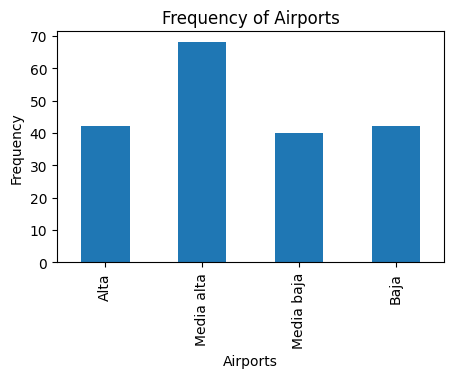

In [11]:
# Quick Univariate Analysis

# Bar Chart for Categorical Variables
# Define the desired order of categories
order = ['Alta', 'Media alta', 'Media baja', 'Baja']

# Reorder the categories in your DataFrame
df['airports'] = pd.Categorical(df['airports'], categories=order, ordered=True)

# Plot the bar chart with the reordered categories
plt.figure(figsize=(5, 3))
df['airports'].value_counts().reindex(order).plot(kind='bar')
plt.title('Frequency of Airports')
plt.xlabel('Airports')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# One-Hot Encode 'airports'
# drop_first=True avoids multicollinearity by dropping the first category.
df_reshaped_encoded = pd.get_dummies(df_reshaped, columns=['airports'], drop_first=True)

# Rename columns in the DataFrame
df_reshaped_encoded.columns = df_reshaped_encoded.columns.str.replace(' ', '_').str.lower()

# Save the dataset
df_reshaped_encoded.to_csv(r"C:\Users\caiov\OneDrive - UCLA IT Services\Documentos\DataScience\Repositories\airline_project\data\with_airports.csv", index=False)

# Define the model
model = smf.ols('nps ~ improved_counter_service * post * airports_media_alta + '
                 'improved_counter_service * post * airports_media_baja + '
                 'improved_counter_service * post * airports_baja',
                 data=df_reshaped_encoded).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    nps   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     93.83
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          1.24e-115
Time:                        23:44:15   Log-Likelihood:                -1472.3
No. Observations:                 384   AIC:                             2977.
Df Residuals:                     368   BIC:                             3040.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

* What attribute would you use for post-stratification?
    * airports

* High-Demand Airports:
    * Average Treatment Effect (without stratification): The coefficient for `improved_counter_service` is -47.9837. This is the effect of improved counter service on NPS, but this effect does not consider the post-period or specific airport types.

* Media Alta Airports:
    * Effect of Improved Counter Service on Media Alta Airports: The coefficient is -47.9837 + 32.3849 = -15.5988. This represents a reduced negative effect in media alta airports.
    * Post-Intervention Effect: -15.5988 + 52.0776 = 36.4788.
    * Confidence Interval: For the `improved_counter_service:post:airports_media_alta[T.True]` coefficient:
        * Coefficient: -12.0181
        * Standard Error: 5.658
        * 95% Confidence Interval: [-23.133, -0.903]

* Media Baja Airports:
    * Effect of Improved Counter Service on Media Baja Airports: The coefficient is -47.9837 + 36.5648 = -11.4189.
    * Post-Intervention Effect: -11.4189 + 52.0776 = 40.6587.
    * Confidence Interval: For the `improved_counter_service:post:airports_media_baja[T.True]` coefficient:
        * Coefficient: -13.6835
        * Standard Error: 6.279
        * 95% Confidence Interval: [-25.942, -1.425]
* Low-Demand Airports:
* Effect of Improved Counter Service on Low-Demand Airports: The coefficient is -47.9837 + 35.9902 = -11.9935.
* Post-Intervention Effect: -11.9935 + 52.0776 = 40.0841.
* Confidence Interval: For the improved_counter_service:post:airports_baja[T.True] coefficient:
    * Coefficient: -10.5136
    * Standard Error: 6.195
    * 95% Confidence Interval: [-22.707, 1.679]

* Implications for the Airline
    * The results suggest that while the improved counter service generally has a positive effect on NPS, the extent of this effect varies by the type of airport and whether it is post-intervention. The treatment appears to be most effective in Media Baja and Low-Demand airports, but the effect in High-Demand airports is less clear and may be negative or not significantly different from zero.

### Question 5

**A colleague suggests generating a sample estimator of the treatment based on pre-measurement scores. What would you respond?**

Answer:

* Your suggestion to generate a sample estimator of the treatment effect using pre-intervention scores is quite valid and can provide valuable insights. Analyzing the data before the intervention allows us to identify any pre-existing trends or differences between groups, which is crucial for ensuring that the observed effects after the intervention are truly due to the treatment and not due to external factors.
* To do this, we can compare the means of pre-intervention scores between the treated and control groups, or fit a regression model using only pre-intervention data to analyze trends. This will give us a solid baseline and help validate the results of the post-treatment analysis, ensuring a more accurate interpretation of the treatment effect.

### Question 6.1

**The first is a simple linear regression where we regress the intervention on the target vector. Report the impact of the estimated coefficient of the intervention. Is this analogous to the estimate generated in point 3?**

For this question, let's consider a simple **Parametric Model**.

**Model Specification**
\begin{equation}
\text{NPS\_post}_i = \beta_0 + \beta_1 \text{improved\_counter\_service}_i + \epsilon_i, i = 1, ..., 192
\end{equation}

Where:
* nps_post: Dependent variable (NPS score).
* improved_counter_service: Indicator variable for treatment group (1 if treated, 0 if control).
* 𝛽1: Coefficient of interest representing the treatment effect.
* ϵ: Error term - represents the collection of other factors affecting NPS.

This scenarion is called: **Treatment Effects**

We are interested in measuring: **The Difference Estimator**

In [13]:
# Fit the linear regression model
X_6_1 = df[['improved_counter_service']]  # Independent variable(s)
X_6_1 = sm.add_constant(X_6_1)  # Add a constant term for beta_0
y_6_1 = df['nps_post']  # Dependent variable

model = sm.OLS(y_6_1, X_6_1).fit()  # Fit the model

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               nps_post   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4.973
Date:                Mon, 26 Aug 2024   Prob (F-statistic):             0.0269
Time:                        23:44:15   Log-Likelihood:                -870.01
No. Observations:                 192   AIC:                             1744.
Df Residuals:                     190   BIC:                             1751.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

From the output we have:

\begin{equation}
\text{NPS\_post} = 64.4227 + 7.2716 \times \text{improved\_counter\_service}
\end{equation}

* Estimates
    * β0 (Intercept): 64.4227
    * **β1 (Coefficient of improved_counter_service - The Difference Estimate)**: 7.2716
        * The estimated effect of the treatment (CounterXP Protocol) on the NPS score is 7.2716. This suggests that, on average, the NPS score is expected to increase by approximately 7.27 points for those who faced the new protocol compared to those who did not.
    * Confidence Intervals:
        * The 95% confidence interval for the coefficient of improved_counter_service is: [0.839, 13.704].
        * This means we are 95% confident that the true effect of the `improved_counter_service` on `nps_post` lies between 0.839 and 13.704.
* R-squared
    * The R-squared value of 0.026 indicates that approximately 2.6% of the variance in the post-intervention NPS score (NPS_post) is explained by the model. Therefore, the vast majority (97.4%) of the variability in `NPS_post` is not explained by the model.
    * The model has a poor fit to the data, indicating that it does not capture the relationships or factors affecting NPS_post effectively.
    
* Implications for the Airline
    * Positive Impact: The positive and statistically significant coefficient indicates that CounterXP has a positive effect on the NPS score. This means that implementing the new protocol is likely to enhance customer satisfaction.
    * Strategic Recommendation: Further Investigation is needed to ensure effective decision-making, conduct a more comprehensive analysis by including additional relevant factors in the model to better understand the treatment's impact and address any other underlying factors affecting NPS scores.

* Comparison
    * β1 (Question 6.1): Difference Estimate = 7.2716
    * β3 (Question 3): Differences-in-Differences Estimate = 26.27
        * This coefficient captures the additional effect of the treatment on the NPS for the treated group relative to the control group after the treatment. **The positive value suggests that the treatment (CounterXP) had a significant positive effect on the NPS in the treated group compared to the control group post-treatment**.

* Conclusion
    * This difference suggests that the simple linear regression, which does not account for time effects or differences between groups prior to the intervention, underestimates the true effect of the intervention. 
    * The DiD method, by considering these factors, provides a more accurate and larger estimate of the intervention's impact, highlighting the importance of accounting for both time and group differences when evaluating treatment effects.

### Question 6.2

**The second is a two-variable linear regression where we regress the intervention and the pre-intervention NPS on the target vector. Report the impact of the estimated coefficient of the intervention. Compared to the regression generated in model 6.1, what is the effect of the intervention on the post-intervention NPS?**

For this question, let's consider a simple **Parametric Model**.

**Model Specification**
\begin{equation}
\text{NPS\_post}_i = \beta_0 + \beta_1 \text{improved\_counter\_service}_i + \beta_2 \text{NPS\_pre}_i + \epsilon_i, i = 1, ..., 192
\end{equation}

Where:
* NPS_post: Dependent variable (NPS score after the intervention).
* improved_counter_service: Indicator variable for the treatment group (1 if treated, 0 if control).
* NPS_pre: Independent variable representing the NPS score before the intervention.
* 𝛽1: Coefficient of interest representing the treatment effect.
* ϵ: Error term - represents the collection of other factors affecting NPS

This regression will give you an estimate for 𝛽1, which represents the treatment effect after controlling for the pre-intervention NPS scores.

In [14]:
# Fit the linear regression model
X_6_2 = df[['improved_counter_service', 'nps_pre']]  # Include both independent variables
X_6_2 = sm.add_constant(X_6_2)  # Add a constant term for beta_0
y_6_2 = df['nps_post']  # Dependent variable

model = sm.OLS(y_6_2, X_6_2).fit()  # Fit the model

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               nps_post   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     279.1
Date:                Mon, 26 Aug 2024   Prob (F-statistic):           3.84e-57
Time:                        23:44:15   Log-Likelihood:                -740.53
No. Observations:                 192   AIC:                             1487.
Df Residuals:                     189   BIC:                             1497.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

From the output we have:

\begin{equation}
\text{NPS\_post} = 3.5902 + 22.2752 \times \text{improved\_counter\_service} + 0.7896 \times \text{NPS\_pre}
\end{equation}

* Estimates
    * β0 (Intercept): 3.5902
        * The intercept represents the expected `NPS_post` when both `improved_counter_service` and `NPS_pre` are 0. 
        * While this value is not directly interpretable in this context, it provides the baseline from which the other coefficients adjust the prediction.
    * β1 (Coefficient of improved_counter_service): 22.2752
        * This suggests that, on average, the NPS score is expected to increase by approximately 22.28 points for those who experienced the new protocol compared to those who did not, holding the pre-intervention NPS score (NPS_pre) constant.
    * β2 (Coefficient of NPS_pre): 0.7896
        * For every one-point increase in the `NPS_pre` score, the `NPS_post` score is expected to increase by approximately 0.7896 points, assuming the treatment status remains constant. 
        * This indicates that the baseline NPS score has a significant impact on the post-intervention NPS score, reflecting that participants with higher pre-intervention scores tend to also have higher post-intervention scores.
* R-squared
    * The R-squared value of 0.747 indicates that approximately 74.7% of the variance in the post-intervention NPS score (NPS_post) is explained by the model.
    * In other words, the model does a good job of accounting for the variability in the post-intervention NPS scores based on the pre-intervention scores and the treatment effect.

* Comparison
    * β1 (Question 6.1): 7.2716
    * β2 (Question 6.2): 22.2752
        * This coefficient captures the additional effect of the treatment on the NPS for the treated group relative to the control group after the treatment. **The positive value suggests that the treatment (CounterXP) had a significant positive effect on the NPS in the treated group compared to the control group post-treatment**.

* Conclusion
    * The second model provides a more complete picture because it accounts for the baseline NPS score, making the treatment effect appear more substantial (22.2752) compared to the first model (7.2716).
    * The R-squared value of the second model is higher, indicating a better fit to the data compared to the first model.

### Question 6.3

**The third is the same regression as in point 6.2, but post-stratified by airports. Report the impact of the estimated coefficient of the intervention for each stratum. Is it possible to identify the effect of the intervention if we control for pre-intervention variables and stratify by airport categories? Is this effect similar for all??**

For this question, let's consider a simple **Parametric Model**, where we include interaction terms for the airport categories. This approach allows you to estimate the treatment effect for each stratum while controlling for pre-intervention variables and stratifying by airport categories.

**Model Specification**
\begin{equation}
\text{NPS\_post}_i = \beta_0 + \beta_1 \text{improved\_counter\_service}_i + \beta_2 \text{airports\_media\_alta}_i
\end{equation}


\begin{equation}
+ \beta_3 \text{airports\_media\_baja}_i + \beta_4 \text{airports\_baja}_i
\end{equation}

\begin{equation}
+ \beta_5 (\text{improved\_counter\_service}_i \times \text{airports\_media\_alta}_i) + \beta_6 (\text{improved\_counter\_service}_i \times \text{airports\_media\_baja}_i)
\end{equation}

\begin{equation}
+ \beta_7 (\text{improved\_counter\_service}_i \times \text{airports\_baja}_i) + \beta_8 \text{NPS\_pre}_i + \epsilon_i
\end{equation}

Where:

* NPS_post: Dependent variable (NPS score after the intervention).
* improved_counter_service: Indicator variable for the treatment group (1 if treated, 0 if control).
* NPS_pre: Independent variable representing the NPS score before the intervention.
* airports: Categorical variable indicating airport categories (media_alta, media_baja, baja).
* improved_counter_service * airports: Interaction terms between the treatment variable and airport categories, capturing the differential impact of the treatment across different airport categories.
* β1: Coefficient representing the overall treatment effect for the base airport category (alta).
* β4, β5, β6: Coefficients for the interaction terms, representing the treatment effect for each airport category (media_alta, media_baja, baja) relative to the base category (alta).
* ϵ: Error term - represents the collection of other factors affecting NPS.

In [ ]:
# One-Hot Encode 'airports' and drop the first category
df_encoded = pd.get_dummies(df, columns=['airports'], drop_first=True)
df_encoded.columns = df_encoded.columns.str.replace(' ', '_').str.lower()

# Save the dataset
df_encoded.to_csv(r"C:\Users\caiov\OneDrive - UCLA IT Services\Documentos\DataScience\Repositories\airline_project\data\with_airports_2.csv", index=False)


In [16]:
# Fit the model with interaction terms
formula = '''
nps_post ~ improved_counter_service * airports_media_alta 
          + improved_counter_service * airports_media_baja 
          + improved_counter_service * airports_baja 
          + nps_pre
'''

model = ols(formula, data=df_encoded).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               nps_post   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     214.6
Date:                Mon, 26 Aug 2024   Prob (F-statistic):           1.04e-88
Time:                        23:44:15   Log-Likelihood:                -647.86
No. Observations:                 192   AIC:                             1314.
Df Residuals:                     183   BIC:                             1343.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

* Estimates
    * β0 (Intercept): -39.9848
        * The intercept represents the expected `NPS_post` when `improved_counter_service`, `NPS_pre`, and the airport categories are all at their reference levels (base category = alta). 
        * This value is not directly interpretable in a meaningful way since it represents a scenario where no intervention or pre-existing conditions exist.
    * β1 (Coefficient of improved_counter_service): 74.2307
        * This suggests that, on average, the NPS score is expected to increase by approximately 74.23 points for those who experienced the new protocol (CounterXP) compared to those who did not, holding the pre-intervention NPS score (`NPS_pre`) constant and for the base airport category (alta).
    * β2 (Coefficient of NPS_pre): 1.3247
    * For every one-point increase in the NPS_pre score, the `NPS_post` score is expected to increase by approximately 1.3247 points, assuming the treatment status and airport category remain constant.
    * This indicates that the baseline NPS score significantly impacts the post-intervention NPS score, reflecting that participants with higher pre-intervention scores tend to have higher post-intervention scores as well.
    * **Impact of the Intervention for Each Stratum**:
        * In the Airport Category Represented by the Intercept (Reference Category = alta): 74.2307
        * airports_media_alta: The effect of the intervention is reduced by 42.8235 compared to the reference category, so the effective impact in this category is 74.2307 − 42.8235 = 31.4072
        * airports_media_baja: The effect is reduced by 58.6739, so the effective impact is 74.2307 − 58.6739 = 15.5568
        * airports_baja: The effect is reduced by 65.8143, so the effective impact is 74.2307 − 65.8143 = 8.4164
    * Interaction Terms:
        * β4 (Coefficient of improved_counter_service * airports_media_alta): -42.8235
        * β5 (Coefficient of improved_counter_service * airports_media_baja): -58.6739
        * β6 (Coefficient of improved_counter_service * airports_baja): -65.8143
            * These coefficients represent the additional effect of the treatment (CounterXP) on the NPS for the treated group relative to the control group across different airport categories. 
            * The negative values indicate that the treatment effect is less pronounced in these categories compared to the base category (alta). 
            * For example, the effect in the media_alta airport category is 42.8235 points lower than in the alta category.
* R-squared: 0.904
    * This high R-squared value indicates that approximately 90.4% of the variance in the NPS_post score is explained by the model. This means that the model does an excellent job of capturing the factors influencing the post-intervention NPS scores, including the treatment effect, pre-intervention scores, and differences across airport categories.

* **¿Es posible identificar el efecto de la intervención si controlamos por variables preintervención y estratificamos por categorías de aeropuertos?**
    * Yes, it is possible to identify the effect of the intervention while controlling for pre-intervention NPS and stratifying by airport categories. The interaction terms allow you to see how the effect of the intervention differs across different categories.
* **¿Es este un efecto similar para todos?**
    * No, the effect of the intervention varies significantly across different airport categories. The intervention has a lower positive impact in the airports_media_alta, airports_media_baja, and airports_baja categories compared to the reference category. The largest reduction in the intervention effect is observed in the airports_baja category.

### Question 7

**How effective is this intervention? Is this intervention identical for all airports? Explain the assumptions behind this intervention that support the causality of your findings.**

* Effectiveness of the Intervention:
    * The intervention appears to be effective overall, as indicated by the positive and significant coefficients of the improved_counter_service variable in the regression models. For the baseline airport category (high demand), the intervention has a substantial positive impact on the NPS, with an average increase of 74.23 points in the post-intervention NPS.

* Differences Across Airports:
    However, the effectiveness of the intervention is not identical across all airports. The interaction coefficients show that in medium-high, medium-low, and low-demand airport categories, the impact of the intervention is significantly lower compared to the high-demand airport category. This suggests that the intervention does not have the same level of effectiveness across different types of airports.

* Assumptions Supporting Causality:
    * SUTVA (Stable Unit Treatment Value Assumption): It is assumed that the effect of the intervention at one airport is not influenced by the intervention at another airport.
    * Ignorability: It is assumed that, after controlling for the NPS_pre variable and airport categories, the assignment to treatment is independent of the potential outcome.
    * Linearity: It is assumed that the relationship between the intervention and post-intervention NPS is linear, and that the interactions adequately capture the differences between airports.

**What are the next steps for this intervention?**

* Deeper Analysis: Conduct a more detailed analysis to understand why the intervention is less effective at certain types of airports. This could involve reviewing specific processes at lower-demand airports or analyzing other contextual variables not considered.

* Pilot Testing at Other Airports: Implement the intervention at additional airports to continue evaluating its effectiveness and make adjustments before a large-scale rollout.

* Continuous Monitoring: Establish a system for ongoing monitoring to track the intervention's effectiveness over time and make necessary adjustments.

**How extrapolable would this intervention be if we want to reach all airports in Brazil? What is the internal and external validity of this exercise?**

* Internal Validity: The internal validity is strong given that the experiment controls for pre-intervention NPS and airport categories. However, the varying effectiveness across different airport types suggests that other unobserved factors might influence the results.

* External Validity: The external validity, or generalizability, might be limited. Since the intervention’s effectiveness varies by airport category, scaling the intervention across all airports in Brazil may require further adjustments to account for the specific needs and contexts of different airports.